<a href="https://colab.research.google.com/github/chambai/Deep_Learning_Course/blob/main/Week%204%20DL%20NLP%201/FakeNewsTextClassify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Text Classification
Adapted from https://towardsdatascience.com/detecting-fake-news-with-deep-learning-7505874d6ac5



There a 2 datasets: Fake and Real.  They originally came from Kaggle: https://towardsdatascience.com/detecting-fake-news-with-deep-learning-7505874d6ac5 but they are also in the GitHub page.  Download the data from the github page, folder: 

**Week 4 Deep NLP 1/data/FakeNews**

Files:  **True.csv** and **Fake.csv**

and upload to your Google drive amd mount the drive in this colab notebook



Edit the code below to specify where the data is in your Google drive

In [ ]:
# load the data into a Pandas dataframe for exploration
import pandas as pd
real = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Course CMP7225 2021/Week 4 DL NLP 1/data/FakeNews/True.csv')
fake = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Course CMP7225 2021/Week 4 DL NLP 1/data/FakeNews/Fake.csv')

Load the python modules

In [ ]:
# Load the modules
import re   # regular expressions modlue (string matching)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# explore the real data
real.head()

# almost all of the real news has the word "Reuters" in the text

In [ ]:
# explore the fake data
fake.head()

The following cells clean the data by removing twitter urls, adding the lables of Fake and Real to the data (this code is specific to this dataset only).

In [ ]:
# clean up the data.  Remove rows that have url's or where the 'text' field is empty
# some rows have url's in, remove these
# dropping rows that have urls as text and date, real's dates look fine, also dropping ones that have no text
fake_drop = fake.drop(index=[9358,15507,15508,18933])

fake_drop = fake_drop.drop(fake_drop.loc[fake_drop.text == ' '].index)
real_drop = real.drop(real.loc[real.text == ' '].index)

Label the data and combine into one dataset for training, then split this training set into a training dataset and a test dataset

In [ ]:
# Give labels to data before combining
fake_drop['fake'] = 1
real['fake'] = 0

combined = pd.concat([fake_drop, real])

## train/test split the text data and labels
features = combined['text']
labels = combined['fake']
#x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = 42)
x_train, x_test, y_train, y_test = train_test_split(features, labels)

Process the text data with the Tokenizer object from Keras.

Stop words will not be removed.  Stop words are words like "a", "and", "but", "how", "or", "what"...

These words shoud be removed if they don't add any new information to the problem.  Classification problems usually don't need stop words as you can get the general idea of the text even if you remove these words.

However stop words will not be removed from this dataset as they can help in identifying the real news from the fake news as there is an underlying difference in the writing quality of the fake and real news which the stop words can help identify.

In [ ]:
## not removing stop words to maintain word context
max_words = 2000    # the maximum number of words to keep, based on word frequency (size of the vocabulary)
max_len = 400       # averge number of words in the 'text' field

token = Tokenizer(num_words=max_words, lower=True, split=' ')
# creates a vocabulary index based on word frequency
# every unique word gets assigned an integer value (0 is reserved for padding). 
# The lower the integer the more frequent the wordword 
# (often the first few are stop words because they appear a lot)
token.fit_on_texts(x_train.values)

# form the tokens into sequences (a list of integers)
# takes each word in the text and replaces it with its corresponding integer value from the previous step
sequences = token.texts_to_sequences(x_train.values)

# pad the sequences - forms the list of sequences into a 2D numpy array of the same length
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)

Embedding layer:

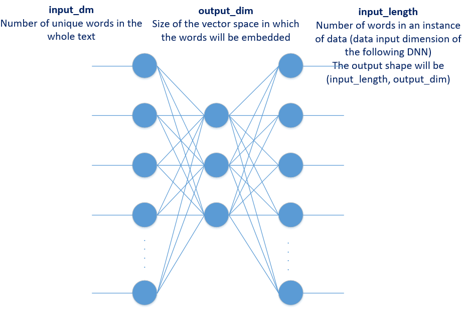

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=50, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

In [ ]:
# compile the model
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
# fit the model
history = model.fit(train_sequences_padded, y_train, batch_size=32, epochs = 20, validation_split=0.2)

In [ ]:
# in the fit method, we set validation_split to use 20% of the training data for the validation
# now we are going to see how our test data performs on the trained network
# to do this we need to create sequences from the test data (ths same way as we did for the training data)
test_sequences = token.texts_to_sequences(x_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
# we can use the evaluate function on the model and pass in the test sequence data to get a value 
# for the loss and accuracy of the network
model.evaluate(test_sequences_padded, y_test)

In [ ]:
# summarize the history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
#plt.axis([None, None,0,1])
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.axis([None, None,0,1])
plt.legend(['train','validation'], loc='upper left')
plt.show()


The accuracy is in the high 90's which is really good.

But remember, most of the data labeled as Real news stories has the word "Reuters" in it.

Let's remove the word "Reuters" from the data and see how it does





In [ ]:
# remove the word reuters from the data
no_reuters = combined.copy()
no_reuters.text = no_reuters.text.str.replace('Reuters', '')


In [ ]:
# split this data into train and test sets
x_train_nr, x_test_nr, y_train_nr, y_test_nr = train_test_split(no_reuters['text'], no_reuters['fake'])

##**Exercise:** Re-create the model without the word 'Reuters' in it
The word "Reuters" has now been removed from the text and stored in x_train_nr etc...  Create the sequences of text, the network, fit the model and plot the accruacy/loss.  Store the model in a different variable to the one above so that both models can be used in the next exercise. How does it compare to the accuracy above (with the word "Reuters" in the data)?

In [ ]:
# your code here

## **Exercise:** Predict whether the following stories are fake or real, using the original model with 'Reuters' in the text and the second model without 'Reuters' in the text. 





In [ ]:
newsstory1 = ["""Democratic freshman Rep. Ilhan Omar (D., Minn.) has been holding a series of secret fundraisers with groups that have been tied to the support of terrorism, appearances that have been closed to the press and hidden from public view.

The content of these speeches, given to predominately Muslim audiences, remains unknown, prompting some of Omar's critics to express concern about the type of rhetoric she is using before these paying audiences, particularly in light of the lawmaker's repeated use of anti-Semitic tropes in public.

Omar recently spoke in Florida at a private event hosted by Islamic Relief, a charity organization long said to have deep ties to groups that advocate terrorism against Israel. Over the weekend, she will appear at another private event in California that is hosted by CAIR-CA PAC, a political action committee affiliated with the Council on American Islamic Relations, or CAIR a group that was named as an unindicted co-conspirator in a massive terror-funding incident.

Omar's appearance at these closed-door forums is raising eyebrows in the pro-Israel world due to her repeated and unapologetic public use of anti-Semitic stereotypes accusing Jewish people of controlling foreign policy and politics. With Omar's popularity skyrocketing on the anti-Israel left, it appears her rhetoric is translating into fundraising prowess.

It remains unclear what Omar has told these audiences in her private talks. Washington Free Beacon attempts to obtain video of past events were unsuccessful, and multiple local news and television outlets in the Tampa, Fla., area, where Omar spoke to Islamic Relief last month, confirmed they were unable to gain access to the closed door event.

Islamic Relief has come under congressional investigation for what lawmakers have described as its efforts to provide assistance to terrorist group such as Hamas and the Muslim Brotherhood. The charity has been banned by some countries as a result of these ties.

In 2017, Congress sought to ban taxpayer funds from reaching the charity due to these terror links.

A representative from Islamic Relief declined to provide the Free Beacon with any material related to Omar's appearance.

"The event was closed to the media. No materials are available," the official said.

On Sunday, Omar will hold another meet and greet in Irvine, Calif., for CAIR-CA PAC. Those wishing to hear Omar speak are being asked to donate anywhere from $50 to $250 dollars, according to a flyer for the event.

The CAIR event also appears closed to the press. Free Beacon attempts to contact the organizer and obtain access were unsuccessful. Requests for comment on the nature of the speeches sent to Omar's congressional office also were not returned.

CAIR, a Muslim advocacy group known for its anti-Israel positions, was named by the U.S. government as part of a large network of groups known to be supporting Hamas.

CAIR has been cited by the Anti-Defamation League, or ADL, for using its network of supporters to promote an "anti-Israel agenda."

"CAIR’s anti-Israel agenda dates back to its founding by leaders of the Islamic Association for Palestine (IAP), a Hamas affiliated anti-Semitic propaganda organization," according to the ADL. "While CAIR has denounced specific acts of terrorism in the U.S. and abroad, for many years it refused to unequivocally condemn Palestinian terror organizations and Hezbollah by name, which the U.S. and international community have condemned and isolated."

Sarah Stern, founder of president of the Endowment for Middle East Truth, or EMET, a pro-Israel group that has condemned Omar for promoting anti-Semitic conspiracy theories, told the Free Beacon that the private nature of these events before controversial Islamic groups is very concerning.

"I just wonder what is Rep. Omar saying to a group of Islamic supporters that she feels is so secretive that she cannot say it to the American people, as a whole?" Stern wondered. "What is so secretive that it has to be off the record and closed to reporters? Will she say the same things in public to her Jewish voters in Minnesota that she says to her Islamic friends? What does this tell us about her openness, her honesty and her integrity?"

One veteran Republican political operative expressed concern about the secretive nature of these talks, telling the Free Beacon that Democrats must hide behind-closed-doors to appease these groups with anti-Israel rhetoric.

"Of course she's holding these meetings in secret. That's just how Democrats roll these days," the source said. "They're for limiting your ability to spend money on the candidates you want to support, and for secretly fundraising from Islamist groups who support them. It really puts their support for campaign finance reform into perspective."

After last month's Islamic Relief event, Stern's EMET and many other pro-Israel groups penned a letter to Democratic leaders in the House demanding Omar's removal from the powerful House Foreign Affairs Committee. These groups argued that Omar's anti-Semitic rhetoric and secretive meetings should disqualify her from a seat on that committee, which oversees the U.S.-Israel military alliance.

"Rep. Omar's presence as a keynote speaker to raise funds for Islamic Relief USA, whose parent organization and chapters have documented ties to terrorist organizations, demonstrates that she has learned next to nothing over the last few weeks when she was reprimanded by your office and by other Democrats for posting ugly, anti-Semitic attacks on Jews and their organizations," the pro-Israel groups wrote in a letter send to House Foreign Affairs Committee chair Elliott Engel (D., N.Y.) and House Speaker Nancy Pelosi (D., Calif.)."""]

In [ ]:
# code here to predict whether newsstory1 is fake or real

In [ ]:
newsstory2 = ["""

Most families of enormous wealth have a dark and sometimes scandalous, even monstrous past. Donald Trump's clan is no exception to that rule. His grandfather was a pimp and a tax evader, his father a racist who would in the course of his life, clash with New York City Police as a member of the Ku Klux Klan and then as a wealthy real estate magnate, refuse to rent to people of color.

Donald Trump's legacy is anything but a rag to riches story. His dad kicked the bucket with $250-$300 million in the bank. The man who wants to ban all people of a particular religion from travel wasn't born with a silver spoon in his mouth, his was white gold. The only thing more obnoxious than Donald Trump himself, is his family's money-grubbing, bigoted history.


Trump's Grandfather: Pimp and Tax Evader

Donald Trump's grandfather, Frederick or Friedrich Trump, made his money from operating a decadent restaurant and hotel during the Gold Rush at Klondike in the Yukon.


"Trump made his first fortune operating boom-town hotels, restaurants and brothels", is more accurate, according to the CBC news report, "Donald Trump's grandfather ran Canadian brothel during gold rush, author says". Author Gwenda Blair simply wrote, "The bulk of the cash flow came from the sale of liquor and sex."

Trump's grandfather was born in Germany, to parents who were employed by a vineyard. He moved to New York City in 1885 where he became a barber. After six years of this, Frederick Trump moved across the United States to Seattle, Washington, where he owned and operated what he referred to as a "decadent restaurant" that was actually called "Poodle Dog" in Seattle's red light district. Interestingly, the name and concept that had already been established in San Francisco. (He named his restaurant after a dog but would later make money selling horse meat) Around this time Frederick Trump became a US citizen.

A Yukon Sun Newspaper writer described his business: "For single men the Arctic has excellent accommodations as well as the best restaurant in Bennett, but I would not advise respectable women to go there to sleep as they are liable to hear that which would be repugnant to their feelings – and uttered, too, by the depraved of their own sex".

Trump moved to Monte Cristo, Wash. in 1894, and then four years later, shortly after the Klondike gold rush began, he relocated again to Bennett, British Columbia.  Here he ran the "Arctic Restaurant and Hotel".  He would next build the "White Horse restaurant and Inn" in Whitehorse, Yukon.

An article published this year by Politico, explains that Frederick Trump sold off his investments and returned to Germany in 1901, as he sensed the end of the gold rush and a subsequent end to prostitution.  The following year, he married his former neighbor, Elizabeth Christ in his native German town of Kallstadt.  Then he came under heavy scrutiny by the German government,

The country had compulsory military service for men which had to be fulfilled by the age of 35.  Donald Trump's grandfather waited until he was 35 to go back to Germany.  He had already amassed great wealth worth well more than half a million US dollars, or 80,000 marks.  While his town council was eager to keep Trump and his money, who billed himself as a man who "avoided bars" and led "a quiet life", other German authorities had a different plan, the Politico article explains.  In their view, Trump had relocated to Germany in order to avoid both tax and military-service obligations.

"...the regional authorities refused to let Trump off the hook. Unlike his grandson, who would become too big to fail in business and, more recently, to ignore in politics, Friedrich Trump was not big enough to get away with being a draft-dodger. He and his wife, then pregnant with Fred, Donald’s father, would not be allowed to resume their German citizenship and it would not be extended to their daughter; instead, they were deported—the same fate that Donald would like to impose on undocumented immigrants in the U.S. today."  

The fact that Donald Trump has done so well in the Republican polls is quite amazing, as the party that we think of as conservative, would be expected to shun a man who created exploitative beauty pageants and was born rich strictly because of the nefarious activities of his ancestors.  

Trump's Father: a Lifetime of Racist Practices

Donald Trump has often said he made his money "the old-fashioned way," and this is true, in that he prospered from racism.


A New York Times article published 01 June 1927, related Donald Trump's father Fred Trump's role in a Ku Klux Klan brawl that pitted 1,000 klansmen against 100 New York City Police in Queens.  Though he wasn't officially charged, Fred Trump was one of seven klansmen arrested during the incident.  It probably wasn't very shocking at the time as America's racist practices were in full swing generations after Abe Lincoln freed the country's African-American slaves.  In fact, the mid-20's saw a peak in KKK activity.  Donald Trump would later deny his father's involvement in the KKK brawl in spite of the fact that it happened two decades before he was born.  Fred Trump's enthusiasm for racist practices never changed until he was forced to do so by the law.

Presidential Candidate Donald Trump joined his father's real estate company in New York in 1971, and only two years later, the company was served with a civil rights lawsuit that was filed against the Trump organization because it refused to rent to Black people.  The Urban League got wind of the racist rental policy and actually sent both Black and White people in to apply for apartments that belonged to complexes owned by the Trumps.  What they proved, was that Black people were denied rentals across the board, and only Whites were approved.  A Village Voice article by Wayne Barrett, published in 1979, blew the lid off the Trump organization's brewing pot of racist practices.

"Three doormen were told to discourage blacks who came seeking apartments when the manager was out, either by claiming no vacancies or hiking up the rents. A super said he was instructed to send black applicants to the central office but to accept white applications on site. Another rental agent said that Fred Trump had instructed him not to rent to blacks. Further, the agent said Trump wanted 'to decrease the number of black tenants' already in the development 'by encouraging them to locate housing elsewhere.'"

The article explains that Trump's reaction was to claim that the suit was a "nationwide drive to force owners of moderate and luxury apartments to rent to welfare recipients."

"'We are not going to be forced by anyone to put people...in our buildings to the detriment of tenants who have, for many years, lived in these buildings, raised families in them, and who plan to continue to live there. That would be reverse discrimination,' he said. 'The government is not going to experiment with our buildings to the detriment of ourselves and the thousands who live in them now.'"   

Indeed, Trump's wild, largely uninformed and unintelligent rants are the legacy of men who walked over the backs of other Americans to gain and secure their wealth.  This may be symbolic of the American capitalist way, but it falls short of any form of greatness or real human success.  As they say, the apple doesn't fall far from the tree.


"""]

In [ ]:
# code here to predict whether newsstory2 is fake or real

If the model correctly predicted it, the prediction should have been close to one as it is a fake

In [ ]:
newsstory3 = ["""
President Donald Trump said Sunday he would extend nationwide social distancing guidelines for another 30 days, an abrupt back-down from his push to reopen the country as coronavirus continues to spread.

The 15-day guidelines Trump announced two weeks ago were set to expire on Monday, and the President had suggested over the past week that he was looking to relax them, at least in some parts of the country. He even floated Easter, on April 12, as a potential date by which the country could return to normal.
But on Sunday he said he'd decided to extend the guidelines -- which include suggested limits on large gatherings -- to April 30, a sign his earlier predictions were overly rosy.
"The better you do, the faster this whole nightmare will end," the President said Sunday at a White House news conference. He said he would be finalizing a new plan and strategy early this week and announcing the details on Tuesday.
The announcement marked an abrupt turnaround from a week ago when Trump said he was convinced the distancing restrictions were causing irreparable damage to the economy.
Even as his health advisers warned of dire consequences if Americans were allowed to return to large gatherings or crowded workplaces, Trump appeared intent on allowing a return to normal life.
On Sunday, however, Trump seemed to acknowledge that the spread of the virus had not slowed, at least not yet. He said that modeling shows that the peak of the death rate will likely hit in two weeks, but stressed that he hopes the country will be on its way to recovery by June 1.
"We can expect that by June 1st, we will be well on our way to recovery, we think by June 1st. A lot of great things will be happening," he said.
Trump reiterated his intent to return life to normal.
"I want our life back again," he said.
The White House's social distancing guidance advises all Americans to avoid groups of more than 10 and urges older people to stay at home.
Over the past week, various options had been discussed among Trump's advisers on possible alternatives -- including allowing some states to return to normal more quickly -- to the current guidelines.
But persistent problems in testing have prevented the full picture of the virus's spread from becoming known, leaving officials without a clear idea of which states were faring better than others.
The scale of the outbreak was given stark urgency Sunday by Dr. Anthony Fauci, the top infectious disease specialist, who predicted on CNN that more than 100,000 Americans could eventually die from coronavirus with millions more infected.
Trump suggested during his briefing that he didn't believe the larger numbers Fauci had mentioned earlier in the day, and called him to the podium.
But Fauci only reiterated the figures he cited earlier.
He said it's "entirely conceivable" that more than a million people in the US could contract coronavirus, but added that mitigation and extending the distancing guidelines through April will hopefully curb those numbers.
Fauci was among the health advisers on Trump's team encouraging a continuation of the current guidelines after Trump heard from business leaders and some conservative allies that the restrictions were more damaging than the virus itself.

Over the course of the past week, however, Trump appeared more wary of lifting the guidelines he had announced himself and which had been branded "President Trump's 15 Days to Slow the Spread."
He said on Friday that his priority in dealing with the virus was Americans' health, not the economy.
And he suggested he was aware that most health professionals would not advise a full-scale return to life as normal.
Questioned Sunday about the Easter date he floated earlier in the week, Trump said it was merely "aspirational."

"""]

In [ ]:
# code here to predict whether newsstory3 is fake or real